# Reconstruct probability distributions using circuit cutting

In [1]:
import math
import numpy as np

from qiskit.circuit import ClassicalRegister
from qiskit.circuit.library import EfficientSU2

from qiskit_addon_cutting import cut_gates, generate_cutting_experiments
from qiskit_addon_cutting.cutting_reconstruction import reconstruct_distribution


def construct_circuit(num_qubits: int, num_measurements: int, reps: int = 1):
    circuit = EfficientSU2(
        num_qubits=num_qubits, reps=reps, entanglement="circular"
    ).decompose()
    circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)

    circuit.add_register(ClassicalRegister(num_measurements))
    for i in range(num_measurements):
        circuit.measure(i, i)

    cut_indices = [
        i
        for i, instruction in enumerate(circuit.data)
        if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, num_qubits - 1}
    ]
    circuit1, bases = cut_gates(circuit, cut_indices)

    return circuit, circuit1, bases

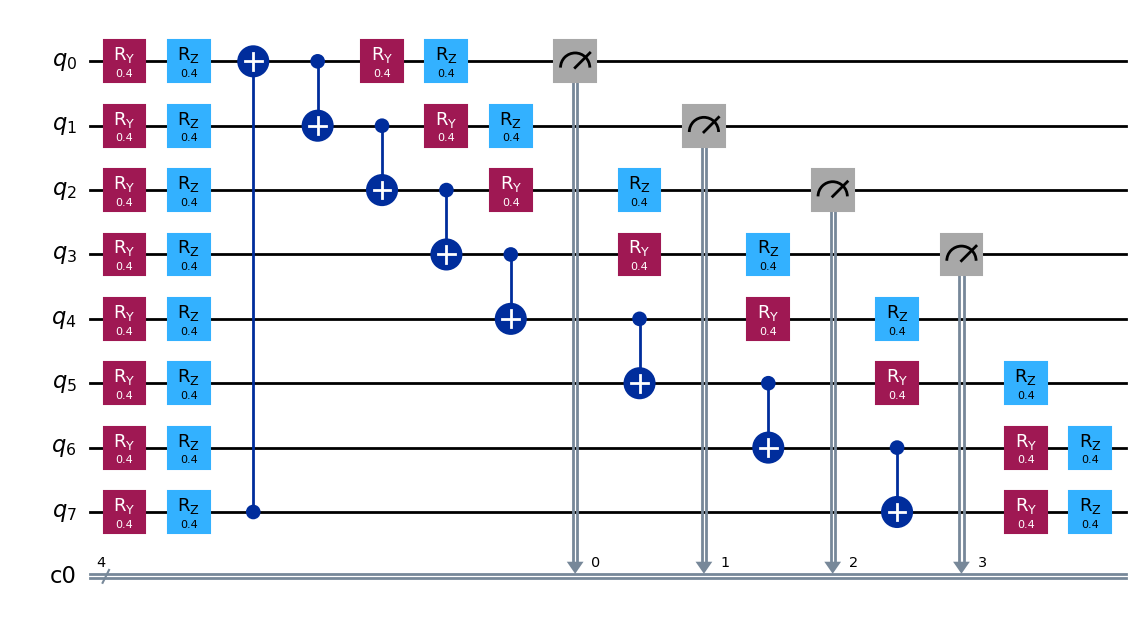

In [2]:
circuit0, circuit1, bases = construct_circuit(8, 4)
circuit0.draw("mpl", fold=-1)

In [3]:
subexperiments, coefficients = generate_cutting_experiments(circuit1, None, np.inf)
coefficients

[(np.float64(0.5), <WeightType.EXACT: 1>),
 (np.float64(0.5), <WeightType.EXACT: 1>),
 (np.float64(0.5), <WeightType.EXACT: 1>),
 (np.float64(-0.5), <WeightType.EXACT: 1>),
 (np.float64(0.5), <WeightType.EXACT: 1>),
 (np.float64(-0.5), <WeightType.EXACT: 1>)]

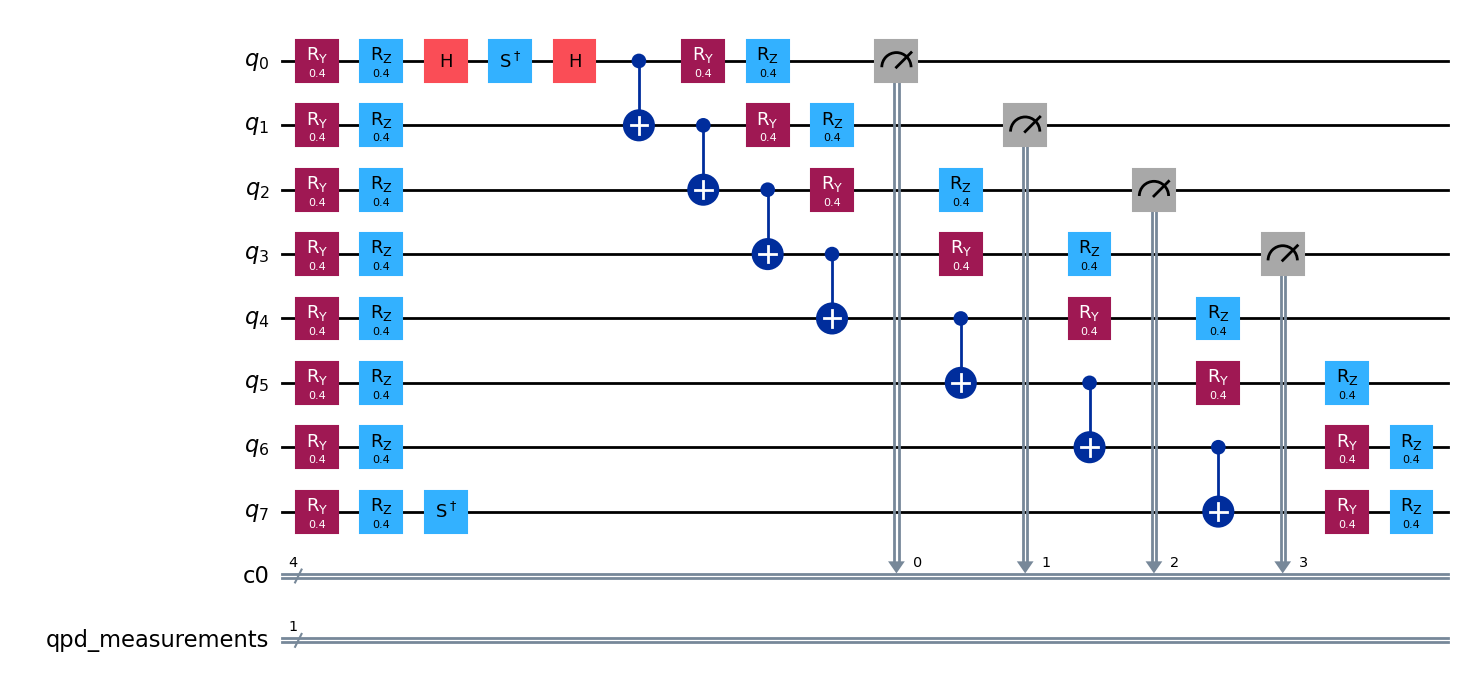

In [4]:
subexperiments[0].draw("mpl")

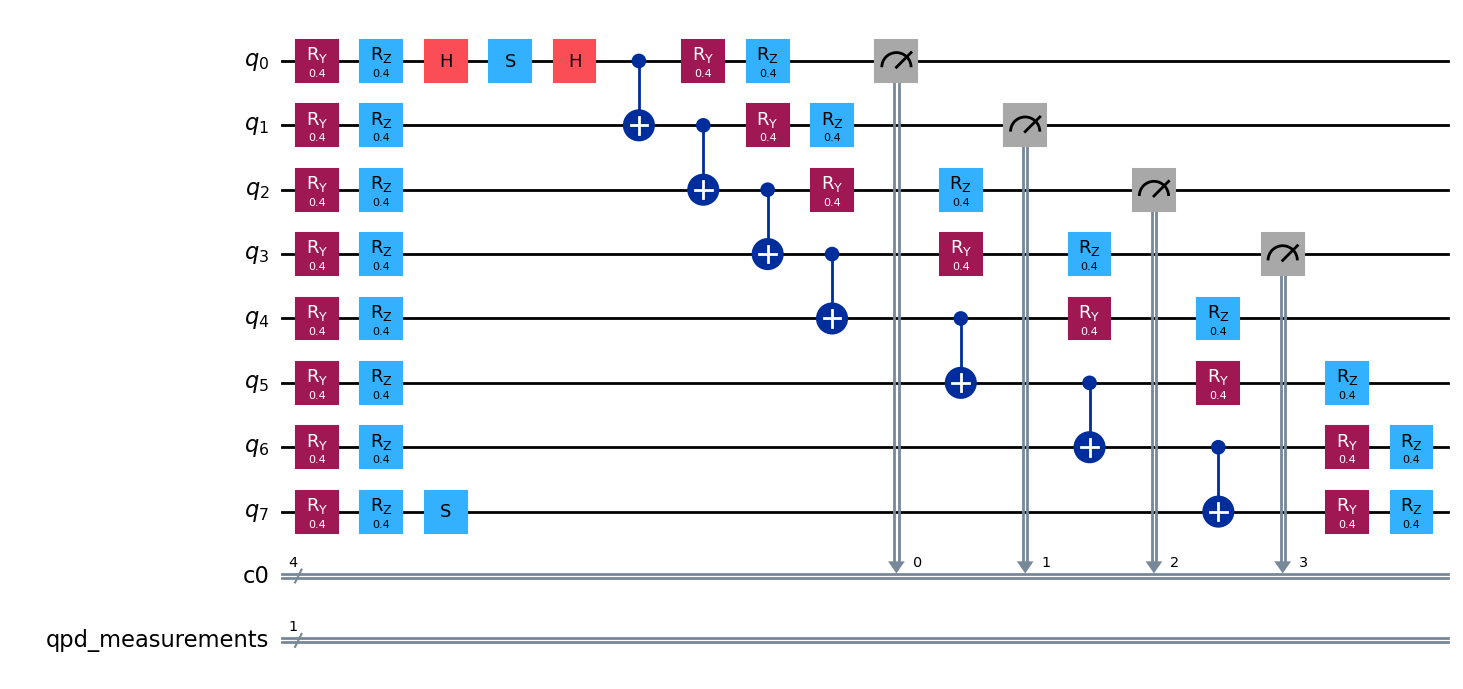

In [5]:
subexperiments[1].draw("mpl")

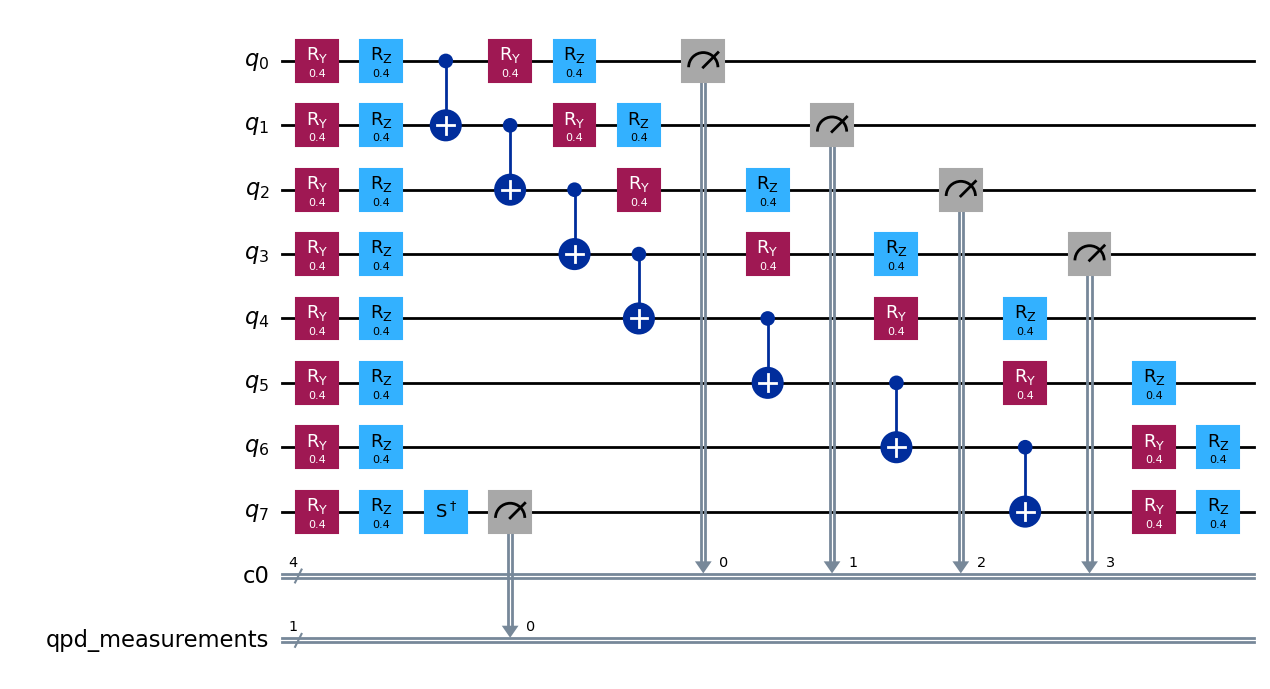

In [6]:
subexperiments[2].draw("mpl")

In [9]:
from qiskit_addon_cutting.utils.simulation import ExactSampler
from qiskit_aer.primitives import Sampler as AerSampler


def sampler_simulator(circuits, shots=None):
    if shots is None:
        sampler = ExactSampler()
    else:
        sampler = AerSampler(run_options={"shots": shots})
    return sampler.run(circuits).result()

In [10]:
shots = 100_000

In [11]:
overhead = np.prod([basis.overhead for basis in bases])
overhead

np.float64(9.0)

In [12]:
results = sampler_simulator(subexperiments, math.ceil(shots * overhead))
results.quasi_dists

/tmp/ipykernel_401049/2802473005.py:1: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = sampler_simulator(subexperiments, math.ceil(shots * overhead))


[{10: 0.001455555555556, 0: 0.307014444444444, 2: 0.016535555555556, 13: 0.008971111111111, 15: 0.491184444444444, 1: 0.023545555555556, 11: 0.011767777777778, 3: 0.021581111111111, 7: 0.03311, 4: 0.01489, 6: 0.002147777777778, 8: 0.028473333333333, 12: 0.021052222222222, 5: 0.000963333333333, 9: 0.004594444444444, 14: 0.012713333333333},
 {10: 0.000968888888889, 5: 0.001318888888889, 9: 0.005304444444444, 15: 0.340854444444444, 1: 0.043063333333333, 0: 0.399225555555556, 2: 0.01844, 7: 0.023908888888889, 3: 0.019854444444444, 11: 0.009303333333333, 14: 0.044105555555556, 12: 0.020673333333333, 4: 0.019884444444444, 8: 0.038047777777778, 6: 0.003447777777778, 13: 0.011598888888889},
 {29: 6.666666667e-06, 22: 0.000166666666667, 21: 5.3333333333e-05, 24: 0.002537777777778, 18: 0.001402222222222, 28: 0.001504444444444, 15: 0.047856666666667, 12: 0.036784444444444, 8: 0.061984444444444, 1: 0.034471111111111, 6: 0.00408, 14: 0.033378888888889, 10: 0.001442222222222, 2: 0.033356666666667, 2

In [13]:
reconstructed = reconstruct_distribution(results, circuit1.num_clbits, coefficients)
reconstructed

[{10: 0.001455555555556, 0: 0.307014444444444, 2: 0.016535555555556, 13: 0.008971111111111, 15: 0.491184444444444, 1: 0.023545555555556, 11: 0.011767777777778, 3: 0.021581111111111, 7: 0.03311, 4: 0.01489, 6: 0.002147777777778, 8: 0.028473333333333, 12: 0.021052222222222, 5: 0.000963333333333, 9: 0.004594444444444, 14: 0.012713333333333}, {10: 0.000968888888889, 5: 0.001318888888889, 9: 0.005304444444444, 15: 0.340854444444444, 1: 0.043063333333333, 0: 0.399225555555556, 2: 0.01844, 7: 0.023908888888889, 3: 0.019854444444444, 11: 0.009303333333333, 14: 0.044105555555556, 12: 0.020673333333333, 4: 0.019884444444444, 8: 0.038047777777778, 6: 0.003447777777778, 13: 0.011598888888889}, {29: 6.666666667e-06, 22: 0.000166666666667, 21: 5.3333333333e-05, 24: 0.002537777777778, 18: 0.001402222222222, 28: 0.001504444444444, 15: 0.047856666666667, 12: 0.036784444444444, 8: 0.061984444444444, 1: 0.034471111111111, 6: 0.00408, 14: 0.033378888888889, 10: 0.001442222222222, 2: 0.033356666666667, 25:

{10: np.float64(0.0015088888888888886),
 0: np.float64(0.660923888888889),
 2: np.float64(0.03344388888888889),
 13: np.float64(0.0008688888888888904),
 15: np.float64(0.0785527777777778),
 1: np.float64(0.03595277777777778),
 11: np.float64(0.001753333333333332),
 3: np.float64(0.006284444444444443),
 7: np.float64(0.0056450000000000024),
 4: np.float64(0.03206666666666667),
 6: np.float64(0.004203888888888889),
 8: np.float64(0.06230111111111111),
 12: np.float64(0.036815555555555546),
 5: np.float64(0.0013633333333333334),
 9: np.float64(0.0039461111111111094),
 14: np.float64(0.03411277777777778)}

In [14]:
sampled = sampler_simulator(circuit0, shots).quasi_dists[0]
sampled

/tmp/ipykernel_401049/855776740.py:1: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampled = sampler_simulator(circuit0, shots).quasi_dists[0]


{13: 0.00083, 0: 0.65889, 2: 0.03365, 4: 0.03245, 15: 0.07863, 1: 0.03627, 14: 0.03483, 12: 0.03708, 5: 0.00144, 9: 0.00413, 8: 0.06223, 6: 0.00423, 7: 0.00564, 3: 0.00648, 11: 0.00174, 10: 0.00148}

In [15]:
exact = sampler_simulator(circuit0).quasi_dists[0]
exact

{0: np.float64(0.661349383557438), 1: np.float64(0.035735918970993), 2: np.float64(0.033372966084964), 3: np.float64(0.006388238923736), 4: np.float64(0.032182698035814), 5: np.float64(0.001399808709105), 6: np.float64(0.004207492698763), 7: np.float64(0.005595572758887), 8: np.float64(0.062317883626069), 9: np.float64(0.004155009279367), 10: np.float64(0.001495554499649), 11: np.float64(0.001581092936103), 12: np.float64(0.036709228053623), 13: np.float64(0.000952453718088), 14: np.float64(0.034008062261882), 15: np.float64(0.07854863588552)}

In [16]:
{bs: (reconstructed[bs] - v0) / (sampled[bs] - v0) for bs, v0 in exact.items()}

{0: np.float64(0.17300866603835663),
 1: np.float64(0.4060410218805279),
 2: np.float64(0.25600765854039415),
 3: np.float64(-1.13113842511495),
 4: np.float64(-0.4340834886873724),
 5: np.float64(-0.9075442704152288),
 6: np.float64(-0.16011736974062582),
 7: np.float64(1.1125435627936908),
 8: np.float64(0.1908491457204457),
 9: np.float64(8.352826372569895),
 10: np.float64(-0.8572689280064842),
 11: np.float64(1.0839064860071357),
 12: np.float64(0.2867733197499294),
 13: np.float64(0.6824196970398663),
 14: np.float64(0.127400788453664),
 15: np.float64(0.05090563923362415)}

In [17]:
{bs: (reconstructed[bs] - v0) for bs, v0 in exact.items()}

{0: np.float64(-0.0004254946685490202),
 1: np.float64(0.00021685880678515984),
 2: np.float64(7.092280392455991e-05),
 3: np.float64(-0.00010379447929181797),
 4: np.float64(-0.0001160313691469933),
 5: np.float64(-3.64753757720244e-05),
 6: np.float64(-3.603809874039819e-06),
 7: np.float64(4.9427241113455915e-05),
 8: np.float64(-1.6772514958129925e-05),
 9: np.float64(-0.00020889816825592385),
 10: np.float64(1.3334389239827698e-05),
 11: np.float64(0.00017224039723061032),
 12: np.float64(0.00010632750193272783),
 13: np.float64(-8.356482919882164e-05),
 14: np.float64(0.00010471551589609496),
 15: np.float64(4.1418922583080775e-06)}

In [18]:
{bs: (sampled[bs] - v0) for bs, v0 in exact.items()}

{0: np.float64(-0.002459383557438022),
 1: np.float64(0.0005340810290073786),
 2: np.float64(0.0002770339150356682),
 3: np.float64(9.176107626373848e-05),
 4: np.float64(0.00026730196418633945),
 5: np.float64(4.0191290894642327e-05),
 6: np.float64(2.250730123707148e-05),
 7: np.float64(4.442724111345352e-05),
 8: np.float64(-8.7883626069242e-05),
 9: np.float64(-2.5009279367033295e-05),
 10: np.float64(-1.555449964906093e-05),
 11: np.float64(0.00015890706389727833),
 12: np.float64(0.00037077194637718386),
 13: np.float64(-0.00012245371808771203),
 14: np.float64(0.0008219377381183182),
 15: np.float64(8.136411448050884e-05)}